In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

In [49]:
class Value:
  def __init__(self, data, _children=(), _op=''):
    self.data = data
    self._prev = _children
    self._op = _op

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    return Value(self.data + other.data, (self, other), '+')
  
  def __mul__(self, other):
    return Value(self.data * other.data, (self, other), '*')

In [59]:
a = Value(3.0)
b = Value(2.0)
c = Value(4.0)

d = a * b + c
d

Value(data=10.0)

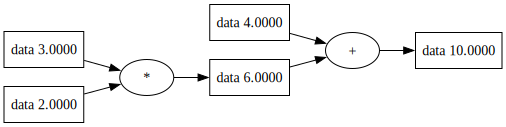

In [120]:
from graphviz import Digraph

def trace(root):
  nodes, edges = set(), set() 
  def build(i):
    if i not in nodes:
      nodes.add(i)
      for child in i._prev:
        edges.add((child, i))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    dot.node(name = uid, label="{ data %.4f }" % (n.data, ), shape='record')
    if n._op:
      dot.node(name = uid + n._op, label=n._op)
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

draw_dot(d)